## Connecting networkX graph

When doing tests, it was discovered that the networkX graph is not strongly connected, so it is not possible to let the inspector drive to each location.

This will be solved in this notebook. However, to do that some assumptions will be made which will bring the resulting network a bit further from the real situation.

In [24]:
%matplotlib inline
import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import pickle
import networkx as nx
from scipy import spatial
import numpy_indexed as npi

In [25]:
# Open old networkX graph
G = pickle.load(open('NetworkX_graph.pickle', 'rb'))

In [26]:
nx.set_edge_attributes(G, 0, 'New_edge')

When a new edge is added using the first method of giving all nodes an incoming and outgoing edge, the 'New_edge' value will be set to 1. If the edge is added using the method to combine the strongly connected components, than this value will be 1. 

The network used is a directional graph, so it can be both strongly (each node can be reached from each node) and weakly (each node can be reached from each node if ignoring the directions of the edges) connected. 

In [27]:
strong = nx.is_strongly_connected(G)
weak = nx.is_weakly_connected(G)

print(f'Check if network is strongly connected: {strong}')
print(f'Check if network is weakly connected: {weak}')

Check if network is strongly connected: False
Check if network is weakly connected: False


When looking at the existing folium maps, a few reasons were discovered for the unconnected network.
- on and off ramps connecting with the regional network. Those regional roads are not part of the network.
- missing data
- highway that is not connected to the main highway network (e.g. Zeeland)

The following algorithm will go over each node and will check if it has no incoming or outgoing nodes. If any of those is missing, The algorithm will loop over the nearest node based on the coordinates. When the nearest node is not the node itself, also not one of the previous 10 or next 10 nodes and within a distance of 100 meters, the nodes will be connected with an edge. The edge of the attributes of the first edge the original node has, will be copied to the new edge. Of course calculating new travel speeds. 

Not all nodes will find a nearby node that complies with the requirements. That's why a new iteration will be run with more relaxed requirements. 

In [28]:
dist_list = [] # list with distances of new edges
 

radius = 100 # max length of an new edge

# Do the iteration 4 times, 2 times with orignal conditions
# And 2 times with relaxed conditions
for i in range(4):
    
    counts = np.zeros(3) # Counts the number of new edges

    if i >= 2:
        radius = 5000 # Relaxed requirement

    # Loop over all nodes
    for node in G:

        # Check if there are no outgoing or incoming edges
        # There are no nodes with no edges at all
        if (len(G.out_edges(node)) == 0) or (len(G.in_edges(node)) == 0):
            counts[0] += 1 # Add count of edge with missing edge

            A = np.array(list(G.nodes())) # Create matrix of node coordinates

            dist, index = spatial.KDTree(A).query(list(node)) # calculate nearest node to original node
            node_near = (A[index][0], A[index][1]) # nearest node is original node at this point

            k = 0
            while((node_near == node)
                  or node_near in nx.predecessor(G, node, cutoff=10) # Check predecessing nodes
                  or node_near in dict(nx.bfs_successors(G, node, depth_limit=10))): # Check successing nodes
                
                k +=-1
                A[index] = [-1, -1]

                dist, index = spatial.KDTree(A).query(list(node))
                node_near = (A[index][0], A[index][1]) # Calculate next nearest node

                # Make sure while loop is not infinite and distance doesn't get too big
                if (k == 20) or (dist >= radius):
                    counts[2] += 1
                    break
            
            # Add new edge if it meets requirements
            if (k != 20) and (dist < radius):
                if (len(G.out_edges(node)) == 0):
                    edge = (node, node_near)
                    edge_list = G.in_edges
                else:
                    edge = (node_near, node)
                    edge_list = G.out_edges
                
                # Add edge and all edge attributes
                G.add_edge(edge[0], edge[1], geometry=[edge[0], edge[1]])

                G.edges[edge]['Max_speed'] = edge_list[list(edge_list(node))[0]]['Max_speed']
                G.edges[edge]['Road_number'] = edge_list[list(edge_list(node))[0]]['Road_number']
                G.edges[edge]['Road_section_id'] = 0
                G.edges[edge]['Peak_speed'] = edge_list[list(edge_list(node))[0]]['Peak_speed']
                G.edges[edge]['Min_travel_time_[s]'] = dist / (edge_list[list(edge_list(node))[0]]['Max_speed'] / 3.6)
                G.edges[edge]['Peak_travel_time_[s]'] = dist / (edge_list[list(edge_list(node))[0]]['Peak_speed'] / 3.6)
                G.edges[edge]['New_edge'] = 1
                

                dist_list.append(dist)
                counts[1] += 1

    print(f'Iteration {i}')
    print(f'{counts[0]} nodes missed an edge')
    print(f'{counts[1]} edges were added')
    print(f'{counts[2]} edges could not be added')
    print()

Iteration 0
1882.0 nodes missed an edge
1619.0 edges were added
263.0 edges could not be added

Iteration 1
251.0 nodes missed an edge
0.0 edges were added
251.0 edges could not be added

Iteration 2
231.0 nodes missed an edge
231.0 edges were added
0.0 edges could not be added

Iteration 3
0.0 nodes missed an edge
0.0 edges were added
0.0 edges could not be added



With the relaxed conditions all edges could be added and have at least one incoming and one outgoing node.

In [29]:
strong = nx.is_strongly_connected(G)
weak = nx.is_weakly_connected(G)

print(f'Check if network is strongly connected: {strong}')
print(f'Check if network is weakly connected: {weak}')

Check if network is strongly connected: False
Check if network is weakly connected: False


However, it is still not strongly connected.

In [30]:
count = 0
lengths = []
large_comp = []
for i in nx.strongly_connected_components(G):
    count += 1
    lengths.append(len(i))

    if len(i) > 50:
        large_comp.append(len(i))

lengths = np.array(lengths)

print(f'There are {count} strongly connected components')
print(f'The maximum component has {np.max(lengths)} nodes')
print(f'And the minimum component has {np.min(lengths)} nodes')
print(f'The whole network has {len(G)} nodes')
print(f'There are only {len(large_comp)} components with a size larger than 50:')
print(large_comp)

There are 432 strongly connected components
The maximum component has 12614 nodes
And the minimum component has 1 nodes
The whole network has 13601 nodes
There are only 1 components with a size larger than 50:
[12614]


As you can see, overall the components are very small.

The next step will be to connect all those small components to the main network. 

For this, there will be looped over all strongly connected components, except for the main network. Each time the selected component will be connected to the most nearby node of another component. A new component is selected (which could be the newly created component) and the process is repeated.

The algorithm will be executed as often as is needed to make the network strongly connected. 

In [31]:
k = 0 # iterator to make sure while loop isn't infinite

A = np.array(list(G.nodes())) # Matrix of all nodes in the network

edge_count = 0 # Counter to check no of edges added


# Execute algorithm as long as network is not strongly connected
while not nx.is_strongly_connected(G):
    # print(f'Iteration {k}')
    
    components = list(nx.strongly_connected_components(G))
    k += 1
    

    sub = components[0]
    # print(len(sub))

        # Check if it is the main network
    if len(sub) > 1000:

        # Create matrix with all coordinates of the main network
        # A = np.array(list(nx.subgraph(G, sub).nodes()))
        sub = components[1]
    
    C = nx.subgraph(G, sub) # Create subgraph
    C_matrix = np.array(list(C.nodes()))
    A_updated = npi.difference(A, C_matrix)

    # Initialize variables
    small_dist = np.inf
    small_index = -1
    closest_node = -1

    # Loop over all nodes in the subgraph
    for node in C:
        
        # Compute the nearest node in the main network
        dist, index = spatial.KDTree(A_updated).query(list(node))
        

        # Check if the new distance is smaller than small_dist
        # If true, update variables
        if dist < small_dist:
            small_dist = dist
            small_index = index
            closest_node = node
    
    # Add edge between closest nodes in main and sub network
    main_node = (A_updated[small_index, 0], A_updated[small_index, 1])
    edge_count += 1
    
    # G.add_edge(closest_node, main_node, geometry=[closest_node, main_node])

    dist_list.append(small_dist)

    edge = (main_node, closest_node)
    edge_list = G.in_edges

    for i in range(2):
        # Add all edge attributes in both directions
        if i == 1:
            edge = (closest_node, main_node)
            edge_list = G.out_edges

        G.add_edge(edge[0], edge[1], geometry=[edge[0], edge[1]])

        G.edges[edge]['Max_speed'] = edge_list[list(edge_list(main_node))[0]]['Max_speed']
        G.edges[edge]['Road_number'] = edge_list[list(edge_list(main_node))[0]]['Road_number']
        G.edges[edge]['Road_section_id'] = 0
        G.edges[edge]['Peak_speed'] = edge_list[list(edge_list(main_node))[0]]['Peak_speed']
        G.edges[edge]['Min_travel_time_[s]'] = dist / (edge_list[list(edge_list(main_node))[0]]['Max_speed'] / 3.6)
        G.edges[edge]['Peak_travel_time_[s]'] = dist / (edge_list[list(edge_list(main_node))[0]]['Peak_speed'] / 3.6)
        G.edges[edge]['New_edge'] = 2
        

    if k == 1000:
        print('Too many iterations')
        break

print(f'{edge_count} x 2 edges were added')

304 x 2 edges were added


Check if network is connected

In [32]:
strong = nx.is_strongly_connected(G)
weak = nx.is_weakly_connected(G)

print(f'Check if network is strongly connected: {strong}')
print(f'Check if network is weakly connected: {weak}')


Check if network is strongly connected: True
Check if network is weakly connected: True


In [33]:
tot_edges = len(G.edges)
tot_min_tt_attributes = len(nx.get_edge_attributes(G, 'Min_travel_time_[s]'))
tot_peak_tt_attributes = len(nx.get_edge_attributes(G, 'Peak_travel_time_[s]'))

print('All attributes have an edge?')
print(tot_edges == tot_min_tt_attributes == tot_peak_tt_attributes)

All attributes have an edge?
True


In [34]:
a = np.array(list(nx.get_edge_attributes(G, 'Min_travel_time_[s]').values()))
a[a == np.nan]

array([], dtype=float64)

So all edges have values for travel time and there are no nan values. Now check the values for distance to the network

In [35]:
dist_list = np.array(dist_list)

The mean length of an edge is 150 m
The median length of en edge is 14 m


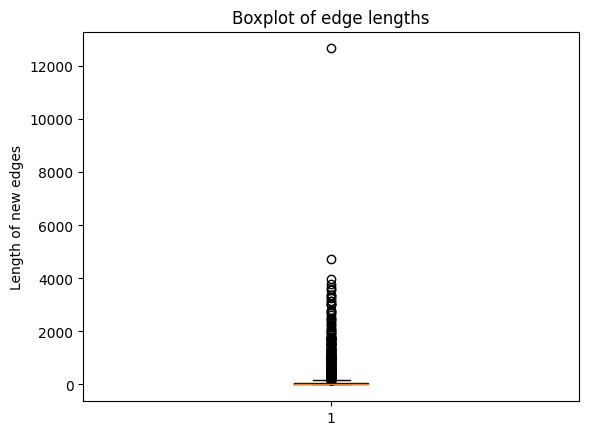

In [36]:
plt.title('Boxplot of edge lengths')
plt.boxplot(dist_list)
plt.ylabel('Length of new edges')
print(f'The mean length of an edge is {np.mean(dist_list):.0f} m')
print(f'The median length of en edge is {np.median(dist_list):.0f} m')

In [37]:
small_edges = len(dist_list[dist_list < 100])
percentage = small_edges / len(dist_list) * 100

bigger_edges = len(dist_list[dist_list < 500])
percentage2 = bigger_edges / len(dist_list) * 100

print(f'{percentage:.0f}% of the edges are smaller than 100 meters')
print(f'{percentage2:.0f}% of the edges are smaller than 500 meters')

80% of the edges are smaller than 100 meters
93% of the edges are smaller than 500 meters


## Checking if the new edges look realistic

In [38]:
new_edge_val = np.array(list(nx.get_edge_attributes(G, 'New_edge').values()))
new_edge_key = np.array(list(nx.get_edge_attributes(G, 'New_edge').keys()))

In [39]:
edge_0 = new_edge_key[new_edge_val == 0]
edge_1 = new_edge_key[new_edge_val == 1]
edge_2 = new_edge_key[new_edge_val == 2]

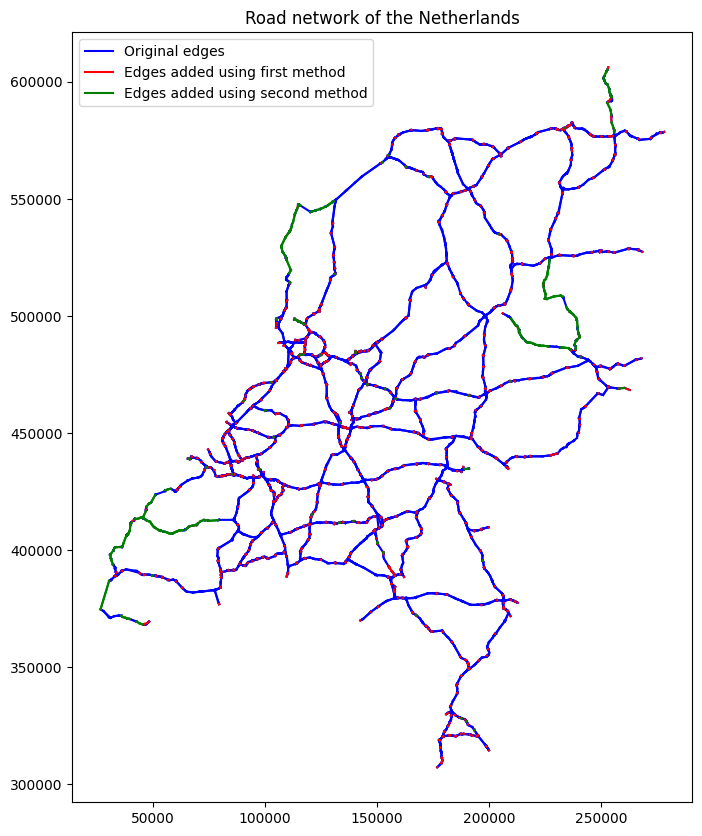

In [40]:
plt.figure(figsize=(8, 10))
plt.title('Road network of the Netherlands')


plt.plot([],[], color='blue', label='Original edges')
plt.plot([],[], color='red', label='Edges added using first method')
plt.plot([],[], color='green', label='Edges added using second method')

for i in range(len(edge_0)):
    plt.plot(edge_0[i,:,0], edge_0[i,:,1], color='blue')

for i in range(len(edge_1)):
    plt.plot(edge_1[i,:,0], edge_1[i,:,1], color='red')

for i in range(len(edge_2)):
    plt.plot(edge_2[i,:,0], edge_2[i,:,1], color='green')


plt.legend()



## Save file

In [41]:
pickle.dump(G, open('NetworkX_graph_new.pickle', 'wb'))